# Laminar flame speed calculations (n-heptane)

In [1]:
import os
import cantera as ct
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import re
import scipy
import scipy.optimize

In [2]:
model_name = 'heptane'
fuel = 'NC7H16'

In [3]:
cantera_file_path = model_name+'.cti'
print(cantera_file_path)
assert os.path.exists(cantera_file_path)
gas = ct.Solution(cantera_file_path)

heptane.cti


In [4]:
phi = 1.0
temperature = 298 # K
pressure = 1 * ct.one_atm
print("T = {} K".format(temperature))
print("P = {} Pa".format(pressure))
gas.set_equivalence_ratio(phi, fuel, 'O2:1.0, N2:3.76')
gas.mole_fraction_dict()
gas.TP = (temperature,pressure)
gas()

T = 298 K
P = 101325.0 Pa

  gas:

       temperature             298  K
          pressure          101325  Pa
           density         1.23452  kg/m^3
  mean mol. weight         30.1879  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -1.1715e+05       -3.537e+06     J
   internal energy     -1.9923e+05       -6.014e+06     J
           entropy            6747        2.037e+05     J/K
    Gibbs function     -2.1278e+06       -6.423e+07     J
 heat capacity c_p          1049.5        3.168e+04     J/K
 heat capacity c_v          774.11        2.337e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.206147         0.218513         -26.2407
                N2       0.775112         0.719281         -23.2878
            NC7H16      0.0187406        0.0622065         -131.483
  

In [36]:
def extrapolate_uncertainty(grids, speeds):
    """
    Given a list of grid sizes and a corresponding list of flame speeds,
    extrapolate and estimate the uncertainty in the final flame speed.
    Also makes a plot.
    """
    grids = list(grids)
    speeds = list(speeds)
    def speed_from_grid_size(grid_size, true_speed, error):
        """
        Given a grid size (or an array or list of grid sizes)
        return a prediction (or array of predictions)
        of the computed flame speed, based on 
        the parameters `true_speed` and `error`
        """
        return true_speed +  error * np.array(grid_size)**-1.

    popt, pcov = scipy.optimize.curve_fit(speed_from_grid_size, grids[-4:], speeds[-4:])

    perr = np.sqrt(np.diag(pcov))
    true_speed  = popt[0]
    percent_error_in_true_speed = 100.*perr[0] / popt[0]
    print("Fitted true_speed is {:.4f} ± {:.4f} cm/s ({:.1f}%)".format(
        popt[0]*100,
        perr[0]*100,
        percent_error_in_true_speed
        ))
    #print "convergerce rate wrt grid size is {:.1f} ± {:.1f}".format(popt[2], perr[2])
    estimated_percent_error = 100. * (speed_from_grid_size(grids[-1], *popt) - true_speed) / true_speed
    print("Estimated error in final calculation {:.1f}%".format(estimated_percent_error))

    total_error_estimate = abs(percent_error_in_true_speed) + abs(estimated_percent_error)
    print("Estimated total error {:.1f}%".format(total_error_estimate))

    plt.semilogx(grids,speeds,'o-')
    plt.ylim(min(speeds[-5:]+[true_speed-perr[0]])*.95, max(speeds[-5:]+[true_speed+perr[0]])*1.05)
    plt.plot(grids[-4:], speeds[-4:], 'or')
    extrapolated_grids = grids + [grids[-1] * i for i in range(2,8)]
    plt.plot(extrapolated_grids,speed_from_grid_size(extrapolated_grids,*popt),':r')
    plt.xlim(*plt.xlim())
    plt.hlines(true_speed, *plt.xlim(), colors=u'r', linestyles=u'dashed')

    plt.hlines(true_speed+perr[0], *plt.xlim(), colors=u'r', linestyles=u'dashed', alpha=0.3)
    plt.hlines(true_speed-perr[0], *plt.xlim(), colors=u'r', linestyles=u'dashed', alpha=0.3)
    plt.fill_between(plt.xlim(), true_speed-perr[0],true_speed+perr[0], facecolor='red', alpha=0.1 )

    #plt.text(grids[-1],speeds[-1],"{:.1f}%".format(estimated_percent_error))

    above = popt[1]/abs(popt[1]) # will be +1 if approach from above or -1 if approach from below
    
    plt.annotate("",
                xy=(grids[-1], true_speed),
                 xycoords='data',
                xytext=(grids[-1], speed_from_grid_size(grids[-1], *popt)),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='|-|',
                                connectionstyle='arc3',
                                color='black', shrinkA=0, shrinkB=0),
                )
        
    plt.annotate("{:.1f}%".format(abs(estimated_percent_error)),
                xy=(grids[-1], speed_from_grid_size(grids[-1], *popt)),
                 xycoords='data',
                xytext=(10,20*above),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->',
                                connectionstyle='arc3')
                )
    
    plt.annotate("",
                xy=(grids[-1]*4, true_speed-(above*perr[0])),
                 xycoords='data',
                xytext=(grids[-1]*4, true_speed),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='|-|',
                                connectionstyle='arc3',
                                color='black', shrinkA=0, shrinkB=0),
                )
    plt.annotate("{:.1f}%".format(abs(percent_error_in_true_speed)),
                xy=(grids[-1]*4, true_speed-(above*perr[0])),
                 xycoords='data',
                xytext=(10,-20*above),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->',
                                connectionstyle='arc3')
                )

    plt.ylabel("Flame speed (m/s)")
    plt.xlabel("Grid size")
    plt.show()
    
    return true_speed, total_error_estimate


In [6]:
def make_callback(flame):
    speeds = []
    grids = []

    def callback(_):
        speed = flame.u[0]
        grid = len(flame.grid)
        speeds.append(speed)
        grids.append(grid)
        print("Iteration {}".format(len(grids)))
        print("Current flame speed is is {:.4f} cm/s".format(speed*100.))
        if len(grids) < 5:
            return 1.0 # 
        try:
            extrapolate_uncertainty(grids, speeds)
        except Exception as e:
            print("Couldn't estimate uncertainty", e.message)
            return 1.0 # continue anyway

        return 1.0
    return callback, speeds, grids

# flame.set_steady_callback(make_callback()[0])

In [7]:
# Domain width in metres
width = 0.015

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define tolerances for the solver
# (these are used throughout the notebook)
#refine_criteria = {'ratio':3, 'slope': 0.1, 'curve': 0.1}
refine_criteria = {'ratio':2, 'slope': 0.05, 'curve': 0.05}
flame.set_refine_criteria(**refine_criteria)
flame.set_max_grid_points(flame.domains[flame.domain_index('flame')], 1e4)

callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

# Define logging level
loglevel = 1


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.068e-05      5.921
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001825      5.124
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.082e-05      6.582
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001849      4.943
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Iteration 1
Current flame speed is is 51.2491 cm/s

..............................................................................
grid refinement disabled.

******************** Solving with grid refinement enabled ********************

.........................................................................

    to resolve AC3H5CHO AC3H5OOH C C2H C2H2 C2H3 C2H3CHCHO C2H3CHO C2H3CO C2H3COC3H7 C2H3COCH3 C2H3OOH C2H4 C2H4O1-2 C2H5 C2H5CHCO C2H5CHO C2H5CO C2H5COC2H3 C2H5COC2H4P C2H5COC2H4S C2H5COC2H5 C2H5COCH2 C2H5COCH3 C2H5O C2H5O2 C2H5O2H C2H5OH C2H6 C3H2 C3H3 C3H4-A C3H4-P C3H5-A C3H5-S C3H5-T C3H5O C3H5OH C3H6 C3H6CHO-1 C3H6CHO-2 C3H6CHO-3 C3H6O1-2 C3H6O1-3 C3H6OH C3H6OOH1-2 C3H6OOH1-2O2 C3H6OOH1-3 C3H6OOH1-3O2 C3H6OOH2-1 C3H6OOH2-1O2 C3H8 C3KET12 C3KET13 C3KET21 C4H10 C4H6 C4H6CHO1-13 C4H6CHO1-14 C4H6CHO1-44 C4H71-1 C4H71-2 C4H71-3 C4H71-4 C4H7CHO1-1 C4H7CHO1-4 C4H7CO1-1 C4H7O C4H7OOH1-4 C4H8-1 C4H8-2 C4H8CHO-1 C4H8CHO-2 C4H8CHO-3 C4H8CHO-4 C4H8O1-2 C4H8O1-3 C4H8O1-4 C4H8O2-3 C4H8OH-1O2 C4H8OH-2O2 C4H8OOH1-2 C4H8OOH1-2O2 C4H8OOH1-3 C4H8OOH1-3O2 C4H8OOH1-4O2 C4H8OOH2-1 C4H8OOH2-1O2 C4H8OOH2-3 C4H8OOH2-3O2 C4H8OOH2-4 C4H8OOH2-4O2 C5H10-1 C5H10-2 C5H10CHO-1 C5H10CHO-2 C5H10CHO-3 C5H10CHO-4 C5H10CHO-5 C5H10O1-2 C5H10O1-3 C5H10O1-4 C5H10O1-5 C5H10O2-3 C5H10O2-4 C5H10OH-1 C5H10OH-2 C5H10OOH1-2 

Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001139      5.118
Attempt Newton solution of steady-state problem...    success.

Problem solved on [44] point grid(s).
Iteration 5
Current flame speed is is 41.3364 cm/s
Fitted true_speed is 41.3761 ± 17.7842 cm/s (43.0%)
Estimated error in final calculation 9.1%
Estimated total error 52.1%


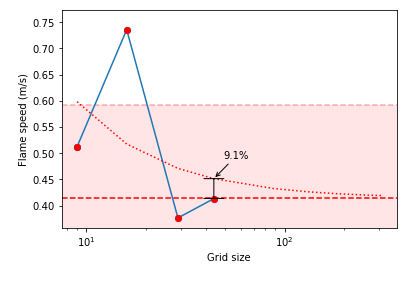


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 7 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
    to resolve AC3H5CHO AC3H5OOH C C2H C2H2 C2H3 C2H3CHCHO C2H3CHO C2H3CO C2H3COC3H7 C2H3COCH3 C2H3OOH C2H4 C2H4O1-2 C2H5 C2H5CHCO C2H5CHO C2H5COC2H3 C2H5COC2H4P C2H5COC2H5 C2H5COCH2 C2H5COCH3 C2H5O2 C2H5O2H C2H5OH C2H6 C3H2 C3H3 C3H4-A C3H4-P C3H5-A C3H5-S C3H5-T C3H5O C3H5OH C3H6 C3H6CHO-1 C3H6CHO-2 C3H6CHO-3 C3H6COC2H5-1 C3H6O1-2 C3H6O1-3 C3H6OH C3H6OOH1-2 C3H6OOH1-2O2 C3H6OOH1-3 C3H6OOH1-3O2 C3H6OOH2-1 C3H6OOH2-1O2 C3H8 C3KET12 C3KET13 C3KET21 C4H10 C4H6 C4H6CHO1-13 C4H6CHO1-14 C4H71-1 C4H71-2 C4H71-3 C4H71-4 C4H7CHO1-1 C4H7CHO1-4 C4H7CO1-1 C4H7OOH1-4 C4H8-1 C4H8-2 C4H8CHO-2 C4H8O1-2 C4H8O1-3 C4H8O1-4 C4H8O2-3 C4H8OH-1O2 C4H8OOH1-2O2 C4H8OOH1-3 C4H8OOH1-3O2 C4H8OOH1-4O2 C4H8OOH2-1O2 C4H8OOH2-3 C4H8OOH2-3O

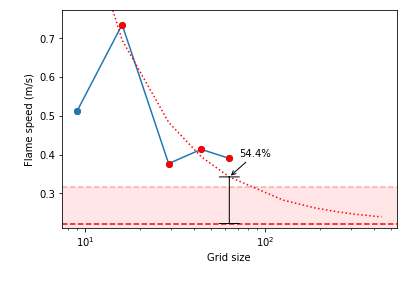


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 39 40 41 47 
    to resolve AC3H5CHO AC3H5OOH C C2H C2H2 C2H3 C2H3CHCHO C2H3CHO C2H3CO C2H3COC3H7 C2H3COCH3 C2H4 C2H4O1-2 C2H5 C2H5CHCO C2H5CHO C2H5COC2H3 C2H5COC2H4P C2H5COCH2 C2H5COCH3 C2H5O2 C2H5O2H C2H5OH C2H6 C3H2 C3H3 C3H4-A C3H4-P C3H5-A C3H5-S C3H5-T C3H5O C3H5OH C3H6 C3H6CHO-1 C3H6CHO-3 C3H6O1-2 C3H6O1-3 C3H6OH C3H6OOH1-2O2 C3H6OOH1-3 C3H6OOH1-3O2 C3H6OOH2-1 C3H6OOH2-1O2 C3H8 C3KET12 C3KET13 C3KET21 C4H10 C4H6 C4H6CHO1-13 C4H6CHO1-14 C4H71-1 C4H71-2 C4H71-3 C4H71-4 C4H7CHO1-1 C4H7CHO1-4 C4H7CO1-1 C4H7OOH1-4 C4H8-1 C4H8-2 C4H8O1-2 C4H8O1-3 C4H8O1-4 C4H8O2-3 C4H8OOH1-2O2 C4H8OOH1-3 C4H8OOH1-3O2 C4H8OOH2-1O2 C4H8OOH2-3O2 C4H8OOH2-4O2 C5H10-1 C5H10-2 C5H10O1-2 C5H10O1-3 C5H10O1-4 C5H10O2-3 C5H10O2-4 C5H1

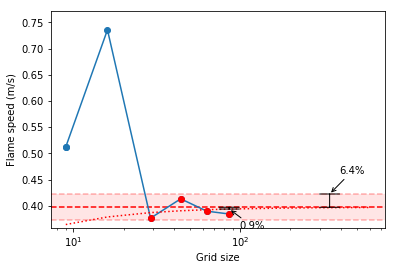


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
    to resolve AC3H5CHO AC3H5OOH C2H C2H2 C2H3 C2H3CHCHO C2H3CHO C2H3CO C2H3COC3H7 C2H3COCH3 C2H4 C2H4O1-2 C2H5 C2H5CHCO C2H5CHO C2H5COC2H3 C2H5COC2H4P C2H5COCH2 C2H5COCH3 C2H5O2 C2H5O2H C2H5OH C2H6 C3H2 C3H3 C3H4-A C3H4-P C3H5-A C3H5-S C3H5-T C3H5O C3H5OH C3H6 C3H6O1-2 C3H6O1-3 C3H6OH C3H6OOH1-2 C3H6OOH1-2O2 C3H6OOH1-3 C3H6OOH1-3O2 C3H6OOH2-1O2 C3H8 C3KET12 C3KET13 C3KET21 C4H10 C4H6 C4H6CHO1-13 C4H6CHO1-14 C4H71-1 C4H71-2 C4H71-3 C4H71-4 C4H7CHO1-1 C4H7CO1-1 C4H7OOH1-4 C4H8-1 C4H8-2 C4H8O1-2 C4H8O1-3 C4H8O1-4 C4H8O2-3 C4H8OOH1-2O2 C4H8OOH1-3 C4H8OOH1-3O2 C4H8OOH2-3O2 C4H8OOH2-4O2 C5H10-1 C5H10-2 C5H10O1-3 C5H10O1-4 C5H10O2-3 C5H10O2-4 C5H10OH-1 C5H10OOH1-2O2 C5H10OOH1-3 C5H10O

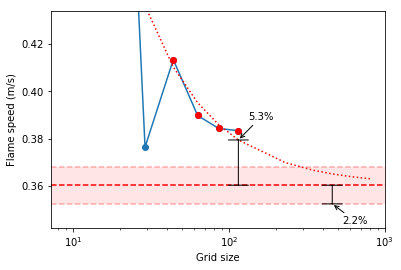


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 78 
    to resolve AC3H5CHO AC3H5OOH C2H C2H2 C2H3 C2H3CHCHO C2H3CHO C2H3CO C2H3COCH3 C2H4 C2H4O1-2 C2H5 C2H5CHCO C2H5CHO C2H5COC2H4P C2H5COCH2 C2H5O2 C2H5O2H C2H5OH C2H6 C3H2 C3H3 C3H4-A C3H4-P C3H5-A C3H5-S C3H5-T C3H5O C3H5OH C3H6 C3H6O1-2 C3H6O1-3 C3H6OH C3H6OOH1-2O2 C3H6OOH1-3O2 C3H6OOH2-1O2 C3H8 C3KET12 C3KET13 C3KET21 C4H10 C4H6 C4H6CHO1-13 C4H6CHO1-14 C4H71-2 C4H71-3 C4H71-4 C4H7CHO1-1 C4H7CO1-1 C4H7OOH1-4 C4H8-1 C4H8-2 C4H8O1-2 C4H8O1-3 C4H8O1-4 C4H8O2-3 C4H8OOH1-2O2 C4H8OOH1-3 C4H8OOH1-3O2 C4H8OOH2-3O2 C4H8OOH2-4O2 C5H10-1 C5H10-2 C5H10O1-3 C5H10O1-4 C5H10O2-4 C5H10OH-1 C5H10OOH1-3 C5H10OOH1-3O2 C5H10OOH2-3O2 C5H10OOH2-

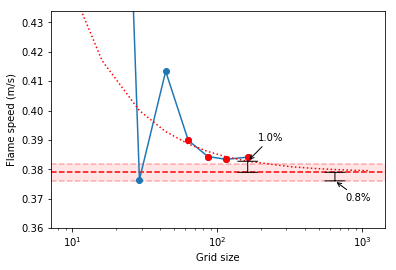


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
    to resolve AC3H5CHO C2H C2H2 C2H3 C2H3CHCHO C2H3CHO C2H3CO C2H4 C2H4O1-2 C2H5 C2H5CHO C2H5COC2H4P C2H5COCH2 C2H5O2 C2H5O2H C2H5OH C2H6 C3H2 C3H3 C3H4-A C3H4-P C3H5-A C3H5-S C3H5-T C3H5O C3H5OH C3H6 C3H6O1-2 C3H6O1-3 C3H6OH C3H6OOH1-2O2 C3H6OOH1-3O2 C3H6OOH2-1O2 C3H8 C3KET13 C4H10 C4H6 C4H6CHO1-13 C4H6CHO1-14 C4H71-2 C4H71-3 C4H71-4 C4H7CHO1-1 C4H7OOH1-4 C4H8-1 C4H8-2 C4H8O1-3 C4H8O1-4 C4H8OOH1-3O2 C4H8OOH2-3O2 C5H10-1 C5H10-2 C5H10O1-3 C5H10O1-4 C5H10O2-4 C5H10OH-1 C5H10OOH1-3O2 C5H10OOH2-4O2 C5H11-1 C5H11-2 C5H11O2-1 C5H11O2-2 C5H11O2-3 C5H81-3 C5H81-4 C5H91-3 C5H91-4 C

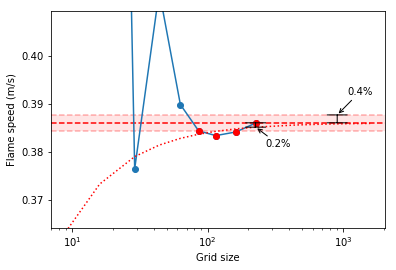


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 126 127 128 129 130 131 132 
    to resolve AC3H5CHO C2H3 C2H5 C2H5CHO C2H5COCH2 C2H5O2 C2H5OH C2H6 C3H3 C3H4-P C3H5-A C3H5O C3H6 C3H8 C4H10 C4H6 C4H71-3 C4H71-4 C4H7OOH1-4 C4H8-1 C4H8-2 C4H8O1-3 C4H8OOH1-3O2 C5H10-1 C5H10-2 C5H10OOH1-3O2 C5H11-1 C5H11-2 C5H11O2-1 C5H11O2-2 C5H81-3 C5H81-4 C5H91-3 C5H91-4 C5H92-4 C5H92-5 C5H9OOH1-4 C5H9OOH1-5 C6H101-3 C6H101-4 C6H101-5 C6H111-4 C6H111O2-4 C6H11OOH1-4 C6H12-1 C6H12-2 C6H12-3 C6H12OOH1-3O2 C6H13-1 C6H13O2-1 C6H13O2-2 C7H131-3 C7H132-4 C7H132-5 C7H133-1 C7H133-5 C7H133-6 C7H14-1 C7H14-3 C7H14O

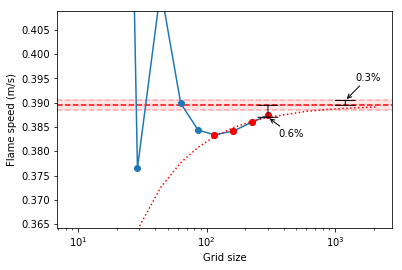


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 
    to resolve C2H5COCH2 C2H5O2 C5H11-1 C5H11O2-1 C5H11O2-2 C6H13O2-1 C7H14OOH1-3O2 C7H14OOH2-3O2 C7H14OOH2-4O2 C7H14OOH3-2O2 C7H14OOH3-4O2 C7H14OOH3-5O2 C7H14OOH4-2O2 C7H14OOH4-3O2 C7H15-1 C7H15-2 C7H15-3 C7H15-4 C7H15O2-1 C7H15O2-2 C7H15O2-3 C7H15O2-4 CH3COCH2 NC3H7O2 NC7KET24 NC7KET35 NC7KET42 PC4H9 PC4H9O2 SC4H9O2 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [331] point grid(s).
Iteration 12
Current flame speed is is 38.7708 cm/s
Fitted true_speed is 39.1165 ± 0.0185 c

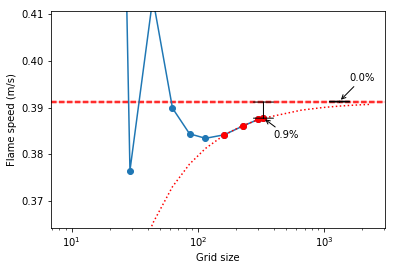


..............................................................................
no new points needed in flame


In [8]:
flame.solve(loglevel=loglevel, auto=True)

Fitted true_speed is 39.1165 ± 0.0185 cm/s (0.0%)
Estimated error in final calculation -0.9%
Estimated total error 0.9%


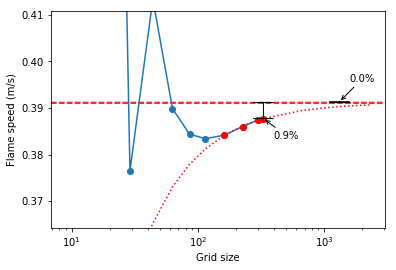

In [43]:
final_true_speed, percentage_uncertainty = extrapolate_uncertainty(grids, speeds)

In [25]:
print("Final grid was size {}".format(grids[-1]))
print("Final speed was {:.4f} cm/s".format(100*speeds[-1]))
print("Estimated uncertainty is {:.1f}%".format(percentage_uncertainty))
print("i.e. {:.3f} +/- {:.3f} cm/s".format(100*speeds[-1],
                                           percentage_uncertainty*speeds[-1]))

Final grid was size 331
Final speed was 38.7708 cm/s
Estimated uncertainty is 0.9%
i.e. 38.771 +/- 0.360 cm/s


At step 4
Grid was size 44
Speed was 41.3364 cm/s
Fitted true_speed is 49.1766 ± 23.7229 cm/s (48.2%)
Estimated error in final calculation 3.7%
Estimated total error 52.0%


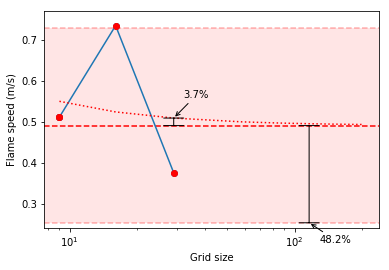

Estimated uncertainty was 52.0%
i.e. 41.336 +/- 21.487 cm/s
or  19.849 -- 62.823 cm/s
(For reference, the 'final' extrapolated speed was 39.117 cm/s
At step 5
Grid was size 63
Speed was 38.9861 cm/s
Fitted true_speed is 41.3761 ± 17.7842 cm/s (43.0%)
Estimated error in final calculation 9.1%
Estimated total error 52.1%


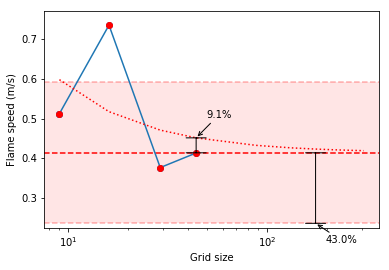

Estimated uncertainty was 52.1%
i.e. 38.986 +/- 20.312 cm/s
or  18.674 -- 59.298 cm/s
(For reference, the 'final' extrapolated speed was 39.117 cm/s
At step 6
Grid was size 86
Speed was 38.4382 cm/s
Fitted true_speed is 22.1634 ± 9.5091 cm/s (42.9%)
Estimated error in final calculation 54.4%
Estimated total error 97.3%


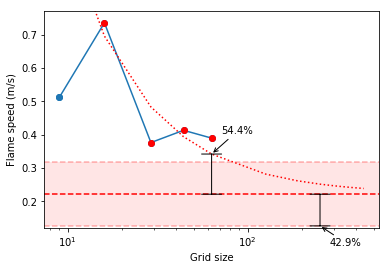

Estimated uncertainty was 97.3%
i.e. 38.438 +/- 37.384 cm/s
or  1.054 -- 75.822 cm/s
(For reference, the 'final' extrapolated speed was 39.117 cm/s
At step 7
Grid was size 115
Speed was 38.3419 cm/s
Fitted true_speed is 39.7321 ± 2.5255 cm/s (6.4%)
Estimated error in final calculation -0.9%
Estimated total error 7.2%


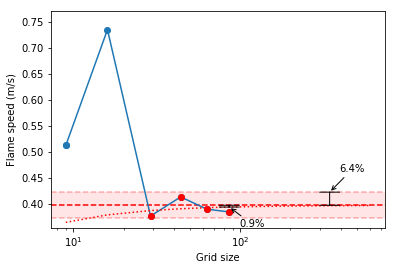

Estimated uncertainty was 7.2%
i.e. 38.342 +/- 2.770 cm/s
or  35.572 -- 41.112 cm/s
(For reference, the 'final' extrapolated speed was 39.117 cm/s
At step 8
Grid was size 162
Speed was 38.4173 cm/s
Fitted true_speed is 36.0485 ± 0.7865 cm/s (2.2%)
Estimated error in final calculation 5.3%
Estimated total error 7.5%


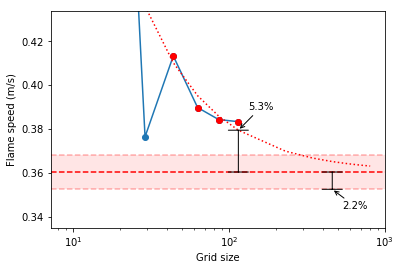

Estimated uncertainty was 7.5%
i.e. 38.417 +/- 2.868 cm/s
or  35.549 -- 41.286 cm/s
(For reference, the 'final' extrapolated speed was 39.117 cm/s
At step 9
Grid was size 226
Speed was 38.6012 cm/s
Fitted true_speed is 37.9015 ± 0.2917 cm/s (0.8%)
Estimated error in final calculation 1.0%
Estimated total error 1.8%


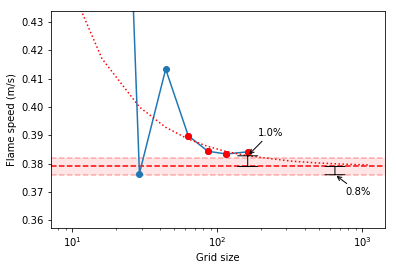

Estimated uncertainty was 1.8%
i.e. 38.601 +/- 0.680 cm/s
or  37.922 -- 39.281 cm/s
(For reference, the 'final' extrapolated speed was 39.117 cm/s
At step 10
Grid was size 301
Speed was 38.7464 cm/s
Fitted true_speed is 38.6068 ± 0.1639 cm/s (0.4%)
Estimated error in final calculation -0.2%
Estimated total error 0.7%


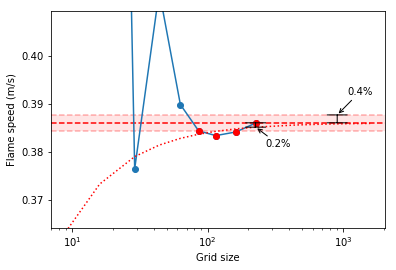

Estimated uncertainty was 0.7%
i.e. 38.746 +/- 0.255 cm/s
or  38.492 -- 39.001 cm/s
(For reference, the 'final' extrapolated speed was 39.117 cm/s
At step 11
Grid was size 331
Speed was 38.7708 cm/s
Fitted true_speed is 38.9466 ± 0.1002 cm/s (0.3%)
Estimated error in final calculation -0.6%
Estimated total error 0.9%


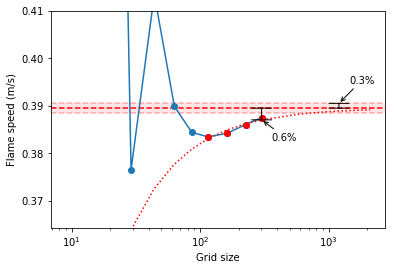

Estimated uncertainty was 0.9%
i.e. 38.771 +/- 0.345 cm/s
or  38.425 -- 39.116 cm/s
(For reference, the 'final' extrapolated speed was 39.117 cm/s


In [46]:
for i in range(4,len(grids)):
    print("At step {}".format(i))
    print("Grid was size {}".format(grids[i]))
    print("Speed was {:.4f} cm/s".format(100*speeds[i]))
    true_speed, percentage_uncertainty = extrapolate_uncertainty(grids[:i], speeds[:i])
    print("Estimated uncertainty was {:.1f}%".format(percentage_uncertainty))
    print("i.e. {:.3f} +/- {:.3f} cm/s".format(100*speeds[i],
                                           percentage_uncertainty*speeds[i]))
    print("or  {:.3f} -- {:.3f} cm/s".format((100-percentage_uncertainty)*speeds[i],
                                           (100+percentage_uncertainty)*speeds[i]))
    print("(For reference, the 'final' extrapolated speed was {:.3f} cm/s".format(100*final_true_speed))
    print("="*80)

And plot some figures just to check things look sensible.

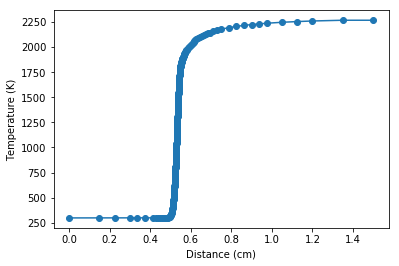

In [47]:
plt.figure()
plt.plot(flame.grid*100, flame.T, '-o')
plt.xlabel('Distance (cm)')
plt.ylabel('Temperature (K)');

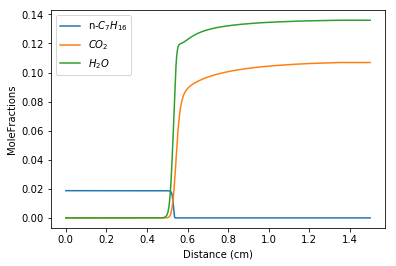

In [50]:
# look up species indices
i_fuel = gas.species_index(fuel)
i_co2 = gas.species_index('CO2')
i_h2o = gas.species_index('H2O')

# Extract concentration data
X_FUEL = flame.X[i_fuel]
X_CO2 = flame.X[i_co2]
X_H2O = flame.X[i_h2o]

plt.figure()

plt.plot(flame.grid*100, X_FUEL, '-', label=r'n-$C_{7}H_{16}$')
plt.plot(flame.grid*100, X_CO2, '-', label=r'$CO_{2}$')
plt.plot(flame.grid*100, X_H2O, '-', label=r'$H_{2}O$')
plt.legend(loc=2)
plt.xlabel('Distance (cm)')
plt.ylabel('MoleFractions');